In [1]:
from PIL import Image
import requests
import os, glob
import pandas as pd
import numpy as np
import re
from transformers import CLIPProcessor, CLIPModel
import importlib
import torch
# Make changes to esd_diffusers.py file here
from eta_diffusion import FineTunedModel, StableDiffuser
import matplotlib.pyplot as plt

/share/u/kevin/miniconda3/envs/new_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from clip_utils import erased_gen, get_clip_scores, get_simple_clip_scores, show_image_grid_with_scores
from clip_utils import interference_gen

In [3]:
import pandas as pd
import torch
import numpy as np
from diffusers import StableDiffusionPipeline, DDIMScheduler

CAR_XATTN_MODEL=""
CAR_GA_MODEL="/share/u/kevin/ErasingDiffusionModels/Gradient_ascent_traininig_scripts/checkpoint/car"
CAR_NOXATTN_MODEL="/share/u/kevin/ErasingDiffusionModels/ESD_training_scripts/models/esd-car_from_car-noxattn_1-epochs_200.pt"

DOG_MODEL="/share/u/kevin/ErasingDiffusionModels/Gradient_ascent_traininig_scripts/checkpoint/english_springer"

pipeline = StableDiffusionPipeline.from_pretrained(DOG_MODEL)
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.safety_checker = None  # Disable the NSFW checker
pipeline = pipeline.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  9.88it/s]


In [4]:
car_images = pipeline("english springer", num_inference_steps=50, generator=torch.manual_seed(2440), eta=0.0).images


  0%|          | 0/50 [00:00<?, ?it/s]

/share/u/kevin/miniconda3/envs/new_env/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 50/50 [00:05<00:00,  8.98it/s]


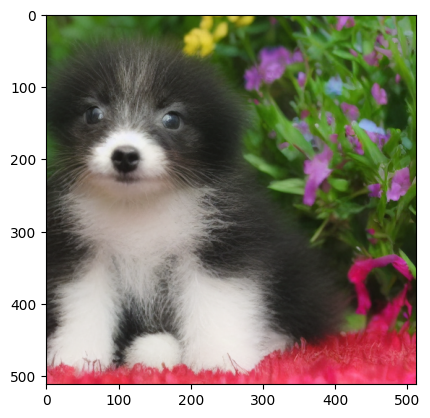

In [5]:
plt.imshow(car_images[0])

In [ ]:
class ExperimentImageSet:
    def __init__(self, stable_diffusion, eta_0_image, attack_images, interference_images = None, prompt: str = None, interference_prompt1 = None, interference_prompt2 = None, seed: int = None):
        self.stable_diffusion: np.ndarray = stable_diffusion
        self.eta_0_image: np.ndarray = eta_0_image
        self.attack_images: np.ndarray = attack_images
        self.interference_images: np.ndarray = interference_images
        self.target_prompt = prompt
        self.seed = seed
        self.interference_prompt1 = interference_prompt1
        self.interference_prompt2 = interference_prompt2

def pipeline_erased_gen(target_csv_path, target_prompt, target_model_path, etas, num_prompts):
    # Load the target and interference CSV files
    target_data = pd.read_csv(target_csv_path)

    torch.cuda.empty_cache()
    variance_scales = [1.0]  # Adjust variance scales as needed

    # Placeholder for the total images and experiment sets
    total_images = []
    total_experiment_sets = []
    ct = 0
    original_pipeline = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
    original_pipeline.scheduler = DDIMScheduler.from_config(original_pipeline.scheduler.config)
    original_pipeline.safety_checker = None  # Disable the NSFW checker
    original_pipeline = original_pipeline.to("cuda")
    pipeline = StableDiffusionPipeline.from_pretrained(target_model_path)
    pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
    pipeline.safety_checker = None  # Disable the NSFW checker
    pipeline = pipeline.to("cuda")

    # Iterate through the target data along with interference data from the other two CSVs
    for index, row in target_data.head(num_prompts).iterrows():

        prompt = row['prompt']
        seed = int(row['evaluation_seed'])
        
        # Base stable diffusion image
        generator = torch.manual_seed(seed)

        
        stable_diffusion = original_pipeline(prompt, num_inference_steps=50, generator=generator, eta=0.0).images[0]
        stable_diffusion = np.array(stable_diffusion)  # Convert to np.ndarray
        total_images.append(stable_diffusion)

        # No attack image (eta=0, variance_scale=0)
        finetuned_no_attack = pipeline(prompt, num_inference_steps=50, generator=generator, eta=0.0).images[0]
        finetuned_no_attack = np.array(finetuned_no_attack)  # Convert to np.ndarray
        total_images.append(finetuned_no_attack)

        # Attack images with varying eta and variance scales
        attack_images = []
        for eta in etas:
            for variance_scale in variance_scales:
                attacked_image = pipeline(
                    prompt,
                    num_inference_steps=50,
                    generator=generator,
                    eta=eta,
                    variance_scale=variance_scale  # Assuming variance_scale is supported directly
                ).images[0]
                attacked_image = np.array(attacked_image)  # Convert to np.ndarray
                attack_images.append(attacked_image)
        attack_images = np.array(attack_images)  # Convert list to np.ndarray
        total_images.extend(attack_images)

        # Construct an experiment set with the images, including the interference images
        experiment_set = ExperimentImageSet(
            stable_diffusion=stable_diffusion,
            eta_0_image=finetuned_no_attack,
            attack_images=attack_images,
            interference_images=None, 
            prompt=target_prompt,
            seed=seed,
            interference_prompt1=None,
            interference_prompt2=None
        )
        total_experiment_sets.append(experiment_set)

        ct += 1 + len(etas) * len(variance_scales)
        print(f"diffusion-count {ct} for prompt: {prompt}")

    # Convert total images to a NumPy array
    total_images = np.array(total_images)

    # Assuming fixed_images is needed as an array of final images
    fixed_images = [image for image in total_images]
    fixed_images = np.array(fixed_images)

    print("Image grid shape:", fixed_images.shape)

    return fixed_images, total_experiment_sets


In [10]:
dog_csv = "/share/u/kevin/ErasingDiffusionModels/Attack_code/Noisy Diffusion(Eta attack)/english_springer_spaniel_50_prompts.csv"
etas=[0.0]
erased_images, erased_sets = pipeline_erased_gen(dog_csv, "English Springer Spaniel", DOG_MODEL, etas, 1)

Loading pipeline components...:  14%|█▍        | 1/7 [00:00<00:01,  4.80it/s]

100%|██████████| 50/50 [00:05<00:00,  9.11it/s]


TypeError: ExperimentImageSet.__init__() got an unexpected keyword argument 'original_interference_images'

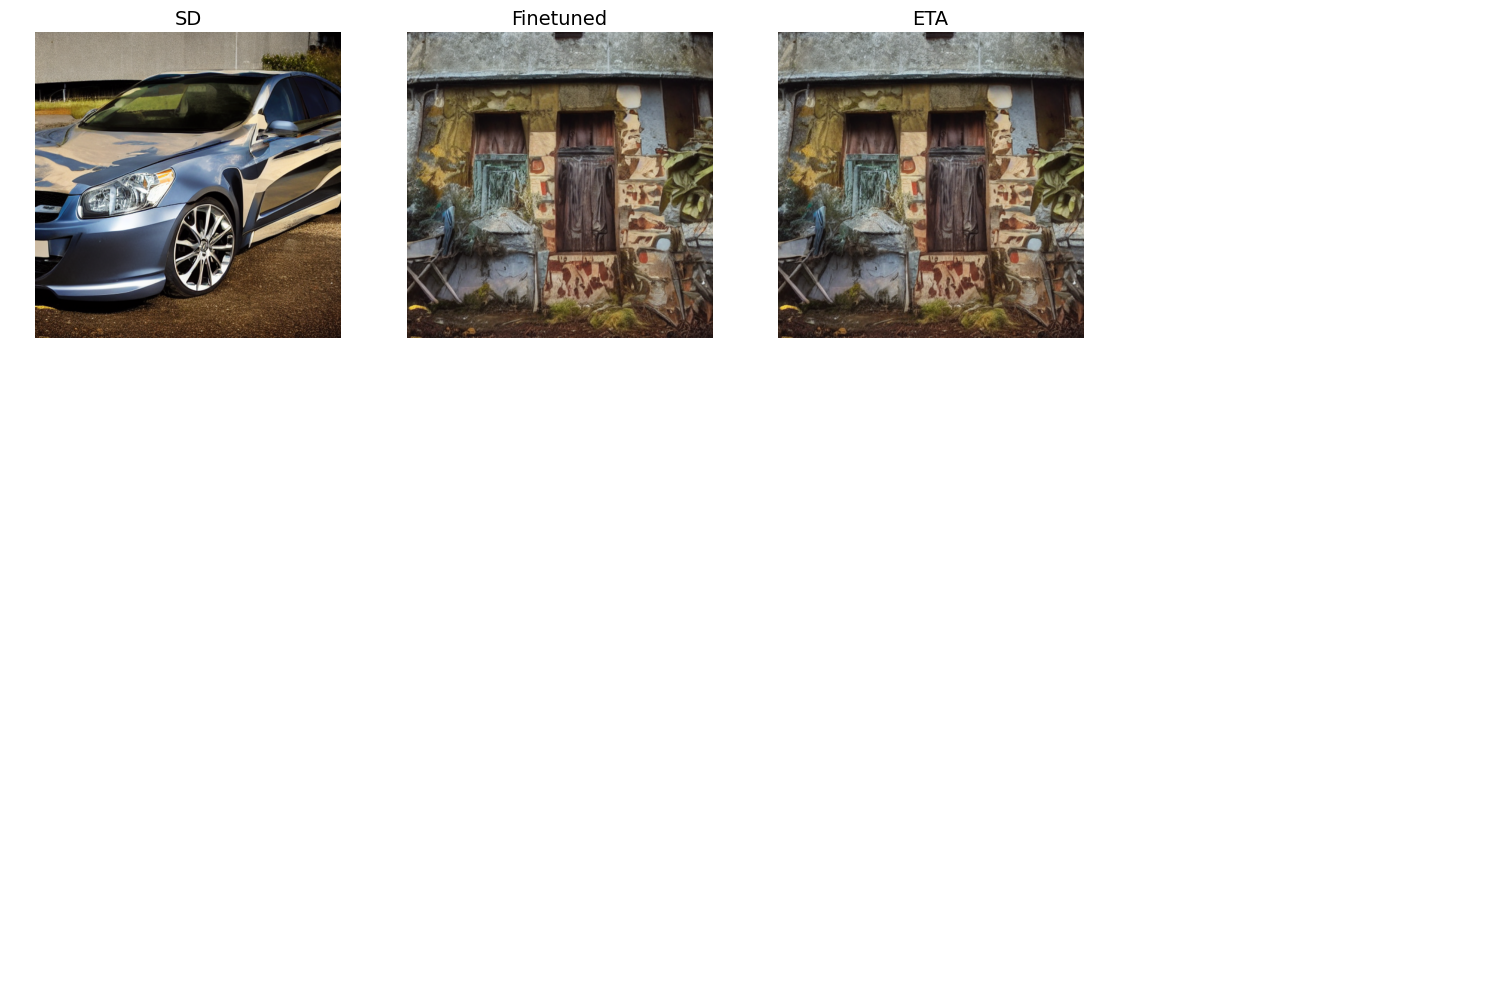

In [23]:
show_image_grid_with_scores(erased_images)

In [13]:
# Initialize the diffuser and finetuner models
state_dict = torch.load(CAR_NOXATTN_MODEL)
diffuser = StableDiffuser(scheduler='DDIM').to('cuda')
finetuner = FineTunedModel(diffuser, train_method="noxattn")
finetuner.load_state_dict(state_dict)


code changed
0.18215


/share/u/kevin/miniconda3/envs/new_env/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
The config attributes {'skip_prk_steps': True} were passed to DDIMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [ ]:
car_noxattn, images_steps, decoded_latents, latents, noise_preds, output_steps = diffuser(
                "a car", 
                n_steps=50, 
                generator=torch.manual_seed(2440), 
                eta=0.0, 
                variance_scale=0.0
            )
car_noxattn = np.array(car_noxattn)


/share/u/kevin/ErasingDiffusionModels/Attack_code/Noisy Diffusion(Eta attack)/eta_diffusion.py:229: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, self.unet.in_channels, img_size // 8, img_size // 8),
100%|██████████| 50/50 [00:05<00:00,  8.81it/s]


latents_steps shape:  (50, 1, 3, 512, 512)


array([[[[134, 115,  90],
         [141, 118,  92],
         [144, 106,  92],
         ...,
         [149, 131,  81],
         [158, 137,  97],
         [141, 123,  91]],

        [[125, 100,  81],
         [136,  99,  81],
         [128, 106,  76],
         ...,
         [146, 132,  69],
         [158, 142,  88],
         [141, 118,  81]],

        [[124,  92,  71],
         [132,  69,  54],
         [161, 105,  61],
         ...,
         [138, 138,  51],
         [155, 144,  72],
         [145, 128,  80]],

        ...,

        [[172, 189, 168],
         [210, 214, 195],
         [207, 224, 208],
         ...,
         [ 85,  90, 184],
         [ 67,  71, 137],
         [ 89,  68, 104]],

        [[168, 172, 156],
         [205, 201, 181],
         [210, 215, 195],
         ...,
         [126, 112, 169],
         [109, 101, 138],
         [114,  94, 106]],

        [[165, 153, 146],
         [171, 155, 159],
         [188, 179, 173],
         ...,
         [124, 102, 135],
        

In [19]:
car_noxattn = car_noxattn.squeeze()

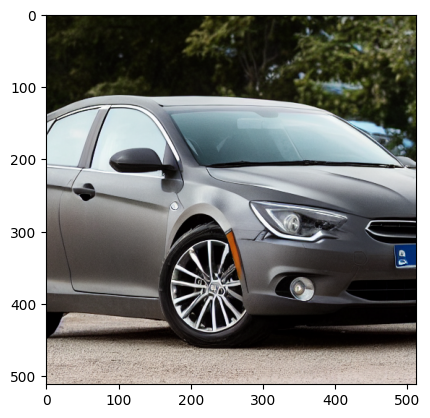

In [20]:
plt.imshow(car_noxattn[49])

In [ ]:
VAN_GOGH_DATA = '/home/lu.kev/ESD_Dataset/vangogh_prompts.csv'
PICASSO_DATA = '/home/lu.kev/ESD_Dataset/picasso_prompts.csv'
ANDY_WARHOL_DATA = '/home/lu.kev/ESD_Dataset/andy_warhol_prompts.csv'

CAR_DATA = '/home/lu.kev/ESD_Dataset/Cleaned Dataset.csv'
VAN_GOGH_XATTN_MODEL = '/home/lu.kev/models/esd-vangogh_from_vangogh-xattn_1-epochs_200.pt'
VAN_GOGH_NOXATTN_MODEL = '/home/lu.kev/models/esd-vangogh_from_vangogh-noxattn_1-epochs_200.pt'
VAN_GOGH_XATTN_GRADASC_10_MODEL = '/home/lu.kev/models/esd-vangogh_from_vangogh-gradientasc_xattn_0-epochs_10.pt'
VAN_GOGH_XATTN_GRADASC_5_MODEL = '/home/lu.kev/models/esd-vangogh_from_vangogh-gradientasc_xattn_0-epochs_5.pt'
VAN_GOGH_NOXATTN_GRADASC_10_MODEL = '/home/lu.kev/models/esd-vangogh_from_vangogh-gradientasc_xattn_0-epochs_10.pt'
VAN_GOGH_NOXATTN_GRADASC_5_MODEL = '/home/lu.kev/models/esd-vangogh_from_vangogh-gradientasc_noxattn_0-epochs_5.pt'
CAR_NOXATTN_MODEL = '/home/lu.kev/ESD_Models/car_noxattn_200.pt'

etas = [0.5, 1.0, 1.5, 2.0]
grad_asc_images, grad_asc_sets = interference_gen('/home/lu.kev/ESD_Dataset/vangogh_prompts.csv', '/home/lu.kev/ESD_Dataset/picasso_prompts.csv', '/home/lu.kev/ESD_Dataset/andy_warhol_prompts.csv', 
                                    VAN_GOGH_NOXATTN_GRADASC_10_MODEL, 'noxattn', etas, 1)

code changed
0.18215


/home/lu.kev/.conda/envs/pytorch_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/lu.kev/.conda/envs/pytorch_env/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
The config attributes {'skip_prk_steps': True} were passed to DDIMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


KeyError: 'unet.down_blocks.0.attentions.0.transformer_blocks.0.attn2.to_q'

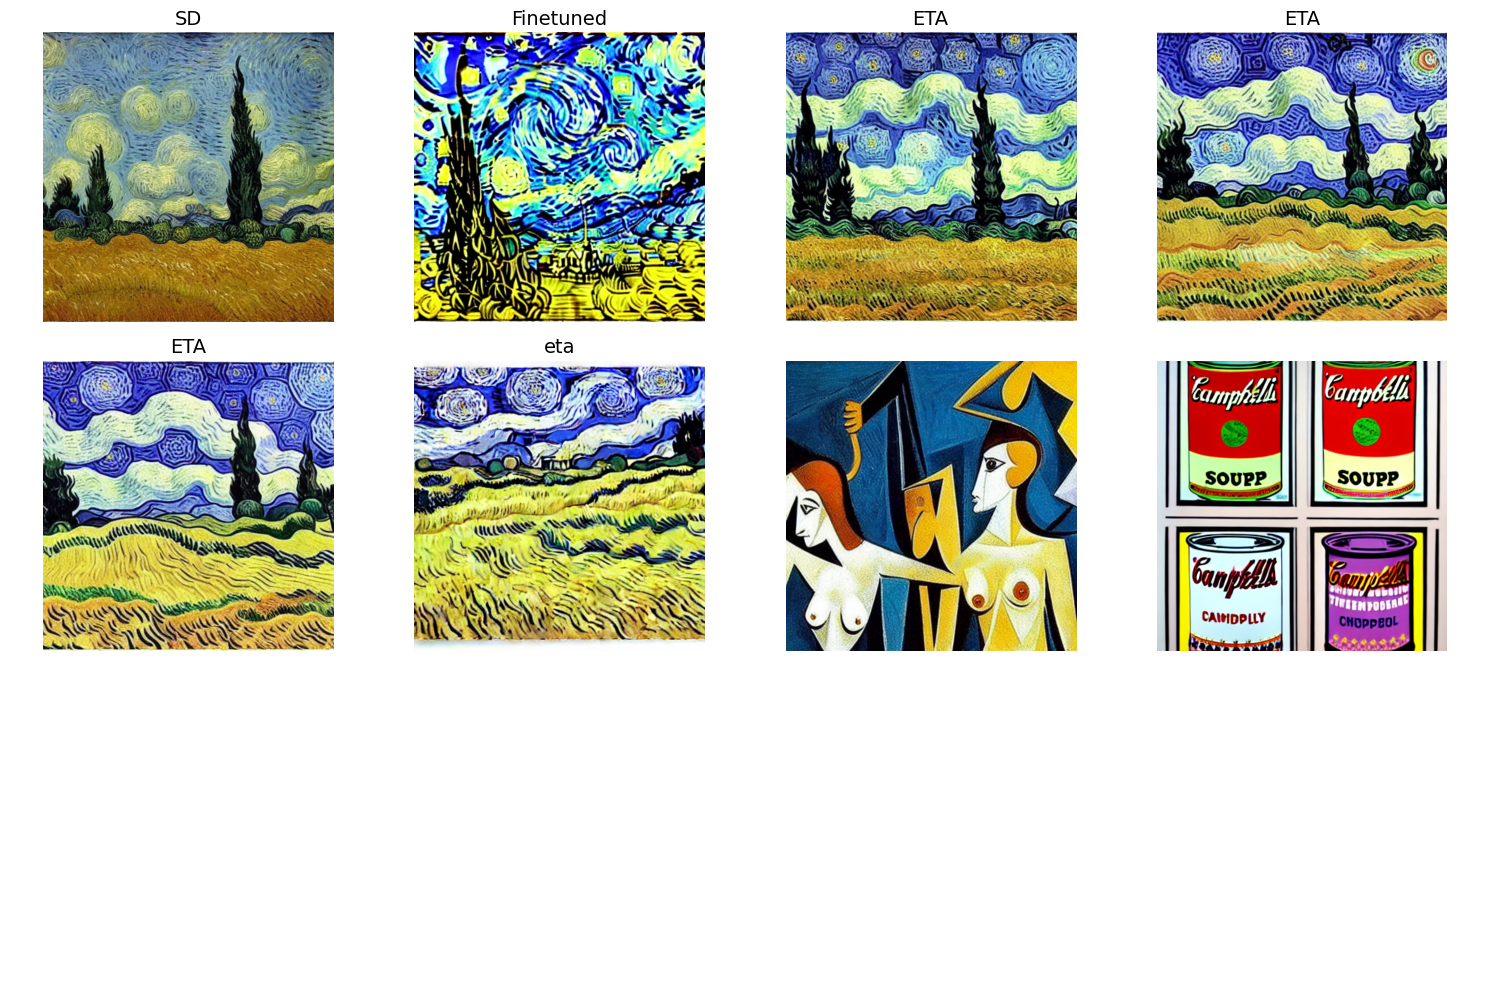

In [ ]:
show_image_grid_with_scores(grad_asc_images)

In [ ]:
grad_clip = get_clip_scores(grad_asc_sets)
print(grad_clip)

(6, 50, 512, 512, 3)
{'SD': 33.143768310546875, 'ETA_0': 29.656784057617188, 'ATTACK': 33.87550735473633, 'INTERFERENCE1': 33.242393493652344, 'INTERFERENCE2': 42.00762939453125}


In [4]:
def process_images(model, processor, prompt: str, images: list):
    """Processes images and returns CLIP scores."""
    images = np.array(images)
    images = images.squeeze()
    print(images.shape)
    images = [image[49] for image in images]
    inputs = processor(text=[prompt], images=images, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    return [clip_score.item() for clip_score in outputs.logits_per_image]

def calculate_experiment_scores(experiment, model, processor):
    """Calculates CLIP scores for each image set in the experiment."""
    targeted_images = [experiment.stable_diffusion, experiment.eta_0_image]
    targeted_images.extend(experiment.attack_images)
    clip_scores = process_images(model, processor, experiment.target_prompt, targeted_images)
    
    scores = {
        'SD': clip_scores[0],  # Stable diffusion image score
        'ETA_0': clip_scores[1],  # ETA_0 image score
        'ATTACK': max(clip_scores[2:]),  # Best attack image score
    }

    if experiment.interference_images:
        interference_images = experiment.interference_images
        interference_images = np.array(interference_images)
        interference_images = interference_images.squeeze()
        interference_images = [interference_image[49] for interference_image in interference_images]
        inputs = processor(text=[experiment.interference_prompt1], images=interference_images[0], return_tensors="pt", padding=True)
        outputs =  model(**inputs)
        interference_1 = outputs.logits_per_image.item()
        
        inputs = processor(text=[experiment.interference_prompt2], images=interference_images[1], return_tensors="pt", padding=True)
        outputs =  model(**inputs)
        interference_2 = outputs.logits_per_image.item()
        scores['INTERFERENCE1'] = interference_1  # Assuming first interference score is used
        scores['INTERFERENCE2'] = interference_2  # Assuming first interference score is used

    return scores
    
def get_experiment_clip_scores(experiment: ExperimentImageSet):
    """
    Processes a single experiment set and returns the following CLIP scores:
    - Stable Diffusion CLIP score
    - Finetuned CLIP score
    - Best attack CLIP score
    - Interference1 CLIP score
    - Interference2 CLIP score

    Args:
        experiment (ExperimentImageSet): The experiment set to process.

    Returns:
        dict: A dictionary containing the scores for SD, finetuned, best attack, interference1, and interference2.
    """
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    # Calculate scores for the experiment set
    scores = calculate_experiment_scores(experiment, model, processor)

    # Return the relevant scores
    result = {
        'SD_CLIP_Score': scores.get('SD', 0),
        'Finetuned_CLIP_Score': scores.get('ETA_0', 0),  # Assuming 'ETA_0' corresponds to fine-tuned model
        'Best_Attack_CLIP_Score': scores.get('ATTACK', 0),
        'Interference1_CLIP_Score': scores.get('INTERFERENCE1', 0),
        'Interference2_CLIP_Score': scores.get('INTERFERENCE2', 0)
    }

    return result


NameError: name 'ExperimentImageSet' is not defined

In [ ]:
clip = get_experiment_clip_scores(grad_asc_sets)

In [ ]:
visualize_experiment_results(grad_asc_sets, clip_scores=clip, prompts = "Wheatfield with Cypress by Van Gogh")

In [ ]:
get_simple_clip_scores()

In [ ]:
import matplotlib.pyplot as plt

def visualize_experiment_results(experiment_sets, clip_scores=None, prompts=None, subtitles=None, num_rows=3, num_cols=4, fig_size=(15, 10)):
    """
    Displays a grid of images with prompts as row headers, subtitles as column headers, and CLIP scores as subtitles.

    Args:
        experiment_sets (list of lists of np.ndarray): List of lists where each sublist contains images for one prompt.
        clip_scores (list of list of float): List of lists of CLIP scores for the images.
        prompts (list of str): List of prompts corresponding to each row of images.
        subtitles (list of str): List of subtitles for the columns (e.g., 'SD', 'Finetuned', 'ETA').
        num_rows (int): Number of rows in the grid (based on the number of prompts).
        num_cols (int): Number of columns in the grid (based on the number of image types per prompt).
        fig_size (tuple): Size of the figure.
    """
    # Create a grid to display the images
    fig, axes = plt.subplots(num_rows, num_cols, figsize=fig_size)
    
    # Set default subtitles if none are provided
    if not subtitles:
        subtitles = ['SD', 'Finetuned', 'ETA', "ETA", "ETA", 'eta']

    # Set column headers (subtitles)
    for col in range(num_cols):
        axes[0, col].set_title(subtitles[col], fontsize=16)

    # Plot each image in the grid row-wise
    for row in range(num_rows):
        if prompts and row < len(prompts):
            # Set row header (prompt)
            axes[row, 0].set_ylabel(prompts[row], fontsize=14, rotation=0, labelpad=80, ha='right', va='center')

        for col in range(num_cols):
            img_index = col  # Image index for this column
            ax = axes[row, col]

            if row < len(experiment_sets) and col < len(experiment_sets[row]):
                img = experiment_sets[row][col]
                ax.imshow(img)

                # Construct subtitle with optional CLIP score
                if clip_scores and row < len(clip_scores) and col < len(clip_scores[row]):
                    subtitle = f"CLIP: {clip_scores[row][col]:.3f}"
                    ax.set_title(subtitle, fontsize=12)

            ax.axis('off')  # Turn off axis labels

    plt.tight_layout()
    plt.show()
visualize_experiment_results(interference_images, )

In [7]:
inteference_clip = get_clip_scores(interference_sets)

(6, 50, 512, 512, 3)
(6, 50, 512, 512, 3)


In [8]:
print(inteference_clip)

{'SD': 34.152557373046875, 'ETA_0': 24.80666160583496, 'ATTACK': 31.32357406616211, 'INTERFERENCE1': 29.03697681427002, 'INTERFERENCE2': 36.03122425079346}


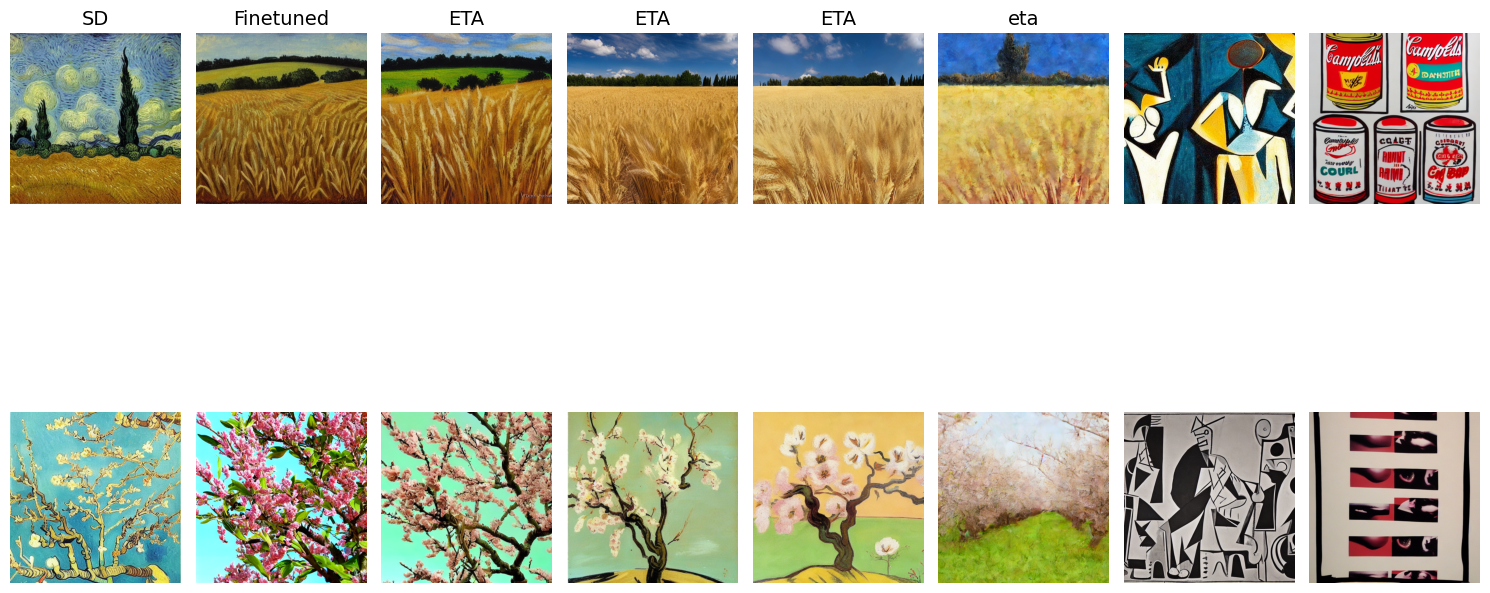

In [11]:
show_image_grid_with_scores(inteference_images, num_rows=2, num_cols=8)

In [ ]:
def visualize_experiment_sets()

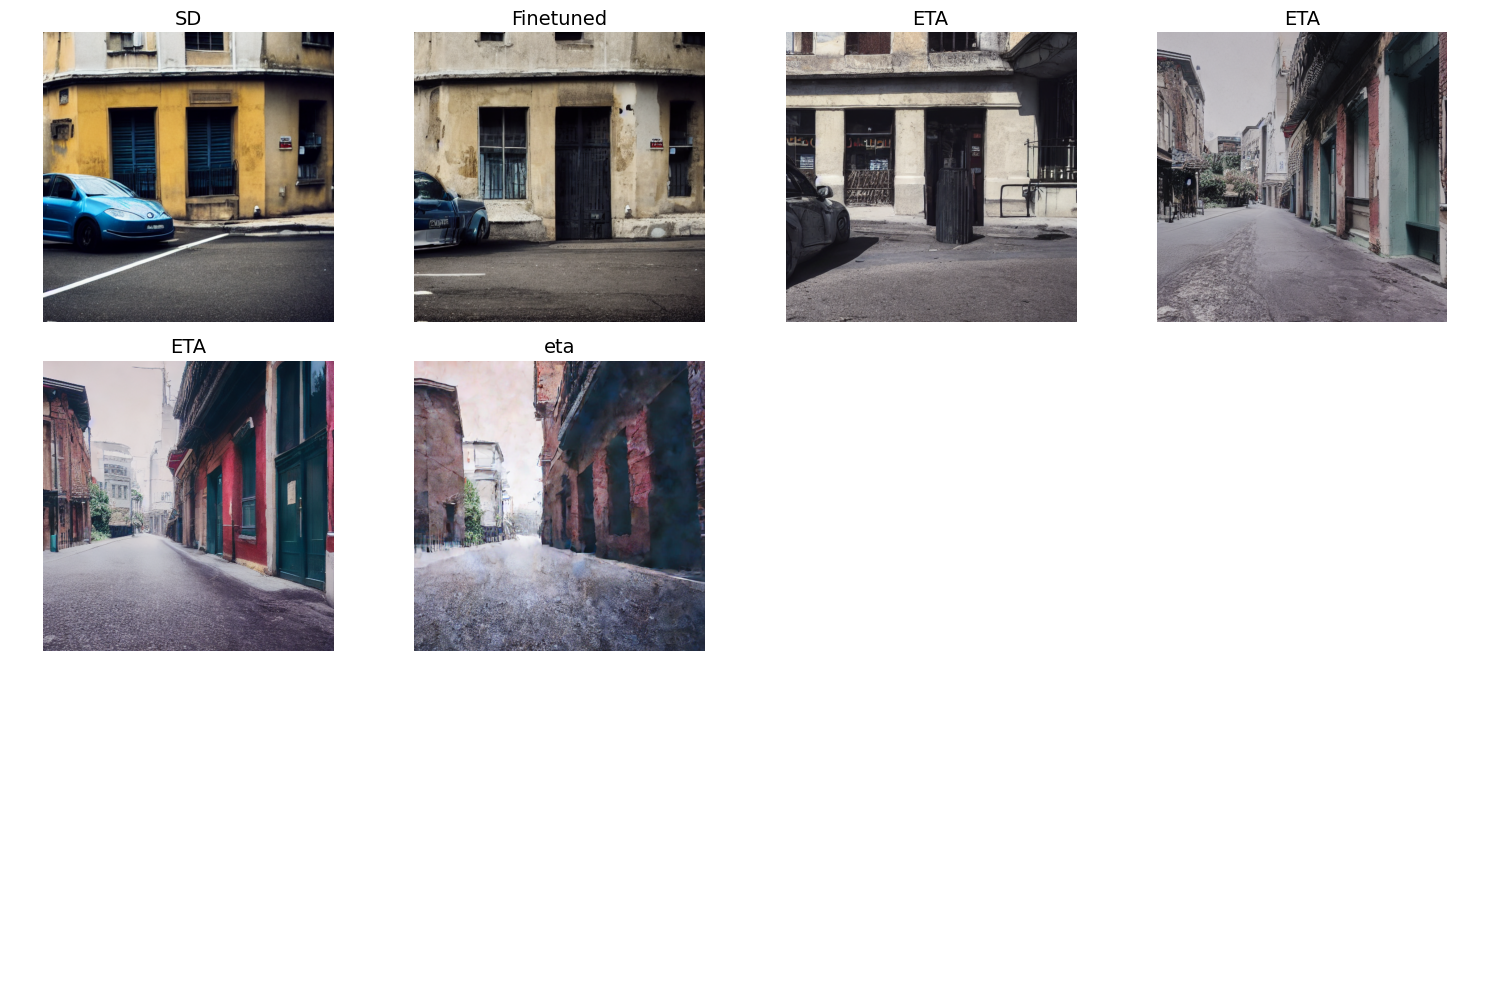

In [4]:
show_image_grid_with_scores(interference_images)

In [5]:
get_clip_scores(erased_sets)

(6, 50, 512, 512, 3)


{'SD': 26.772743225097656,
 'ETA_0': 26.830198287963867,
 'ATTACK': 25.800199508666992,
 'INTERFERENCE': 0.0}

In [8]:
clip = get_simple_clip_scores(erased_images, ['A car on the street']*6)

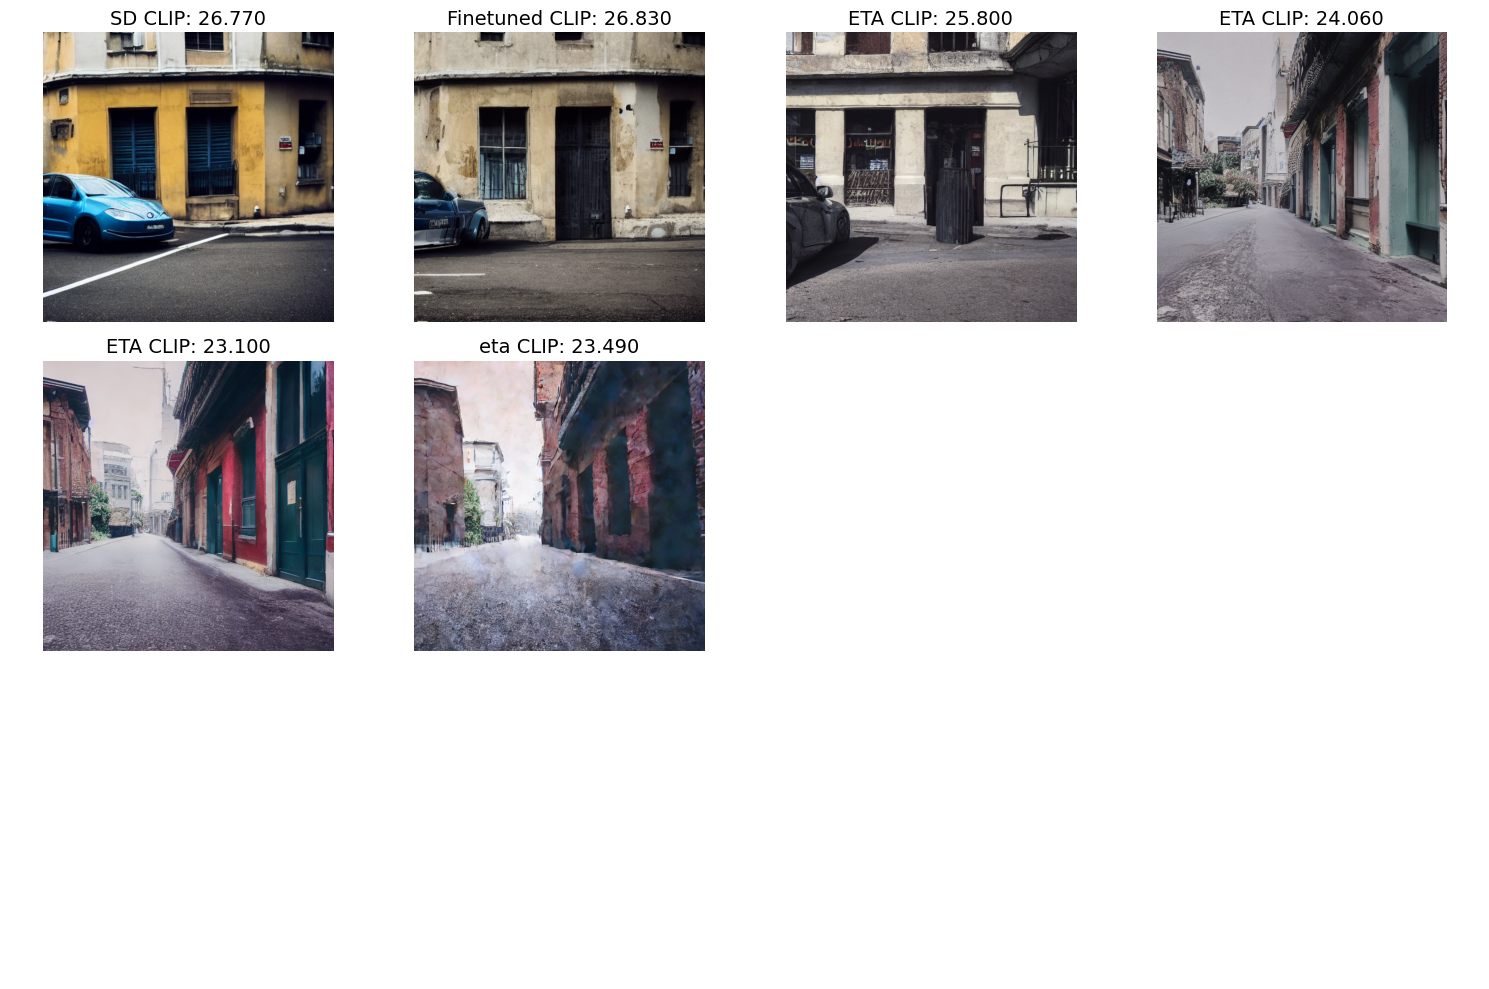

In [10]:
show_image_grid_with_scores(erased_images, clip_scores=clip)

In [11]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities


In [15]:
print(logits_per_image)
print(probs)

tensor([[24.5701, 19.3049]], grad_fn=<TBackward0>)
tensor([[0.9949, 0.0051]], grad_fn=<SoftmaxBackward0>)


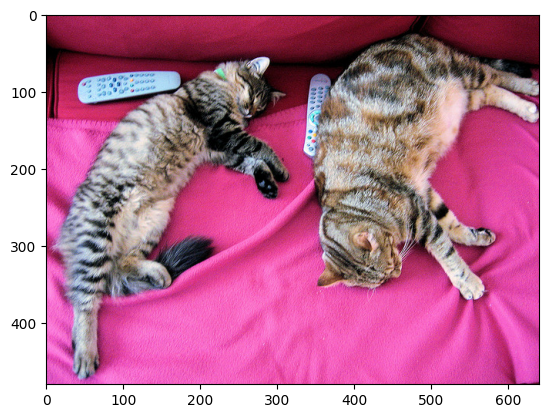

In [16]:
import matplotlib.pyplot as plt

plt.imshow(image)